
--- Iteration 1 ---
9.979467 3.2677073 0.3528636


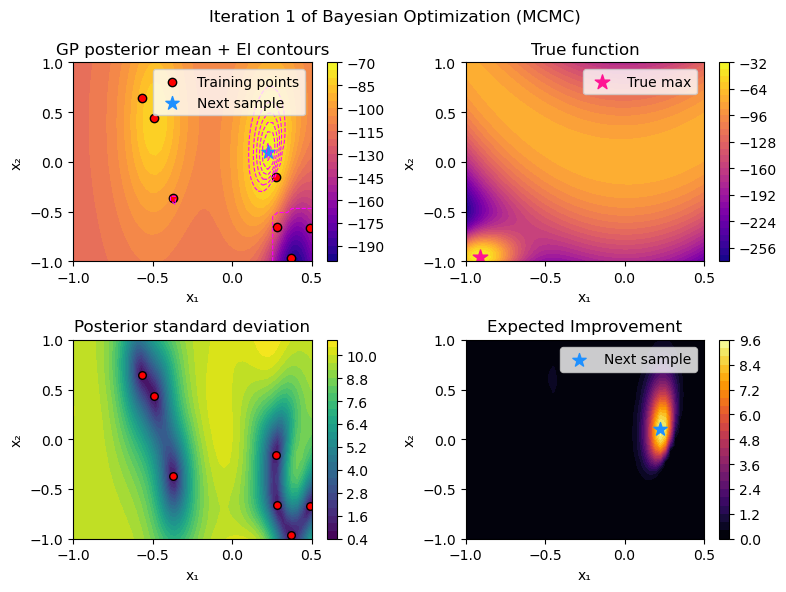


--- Iteration 2 ---
9.977804 2.0367813 0.7054411


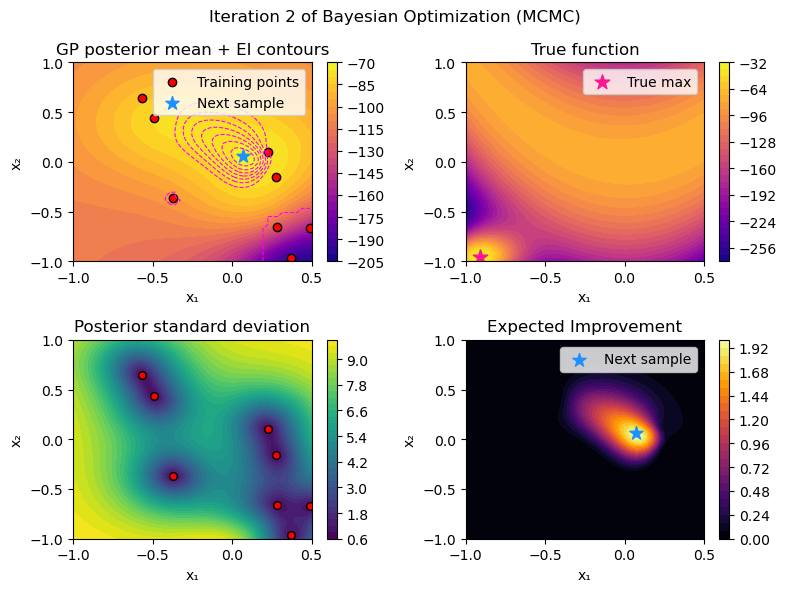


--- Iteration 3 ---
9.978951 2.045612 0.67812836


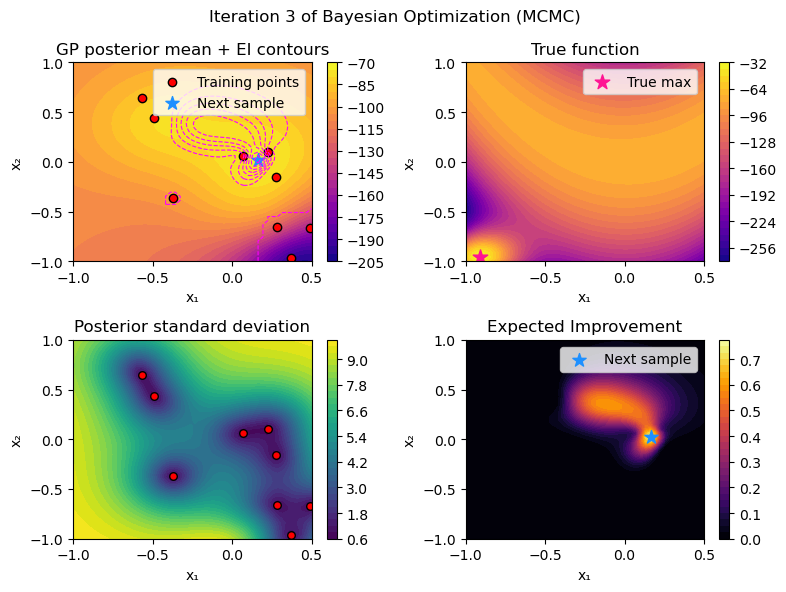


--- Iteration 4 ---
9.980887 2.0272136 0.7767299


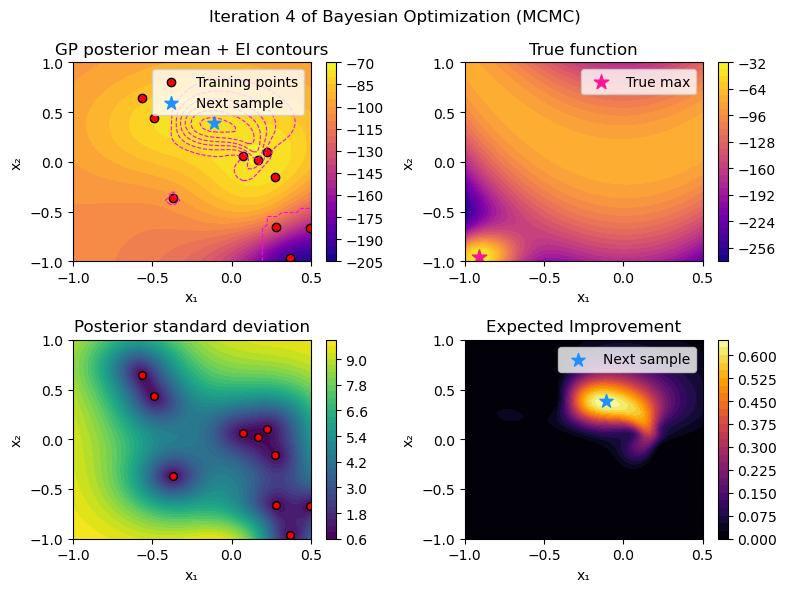


--- Iteration 5 ---
9.9838295 2.0039268 0.76324815


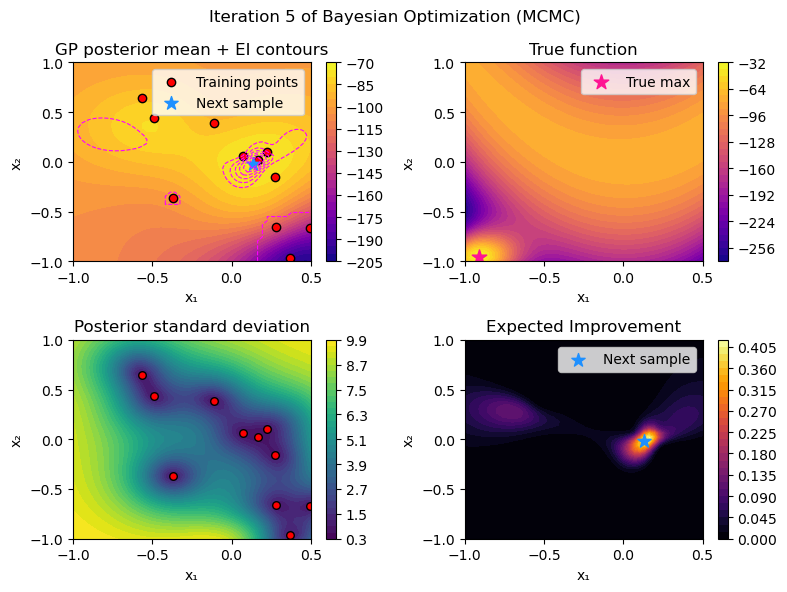


--- Iteration 6 ---
9.9820795 2.0251808 0.5923209


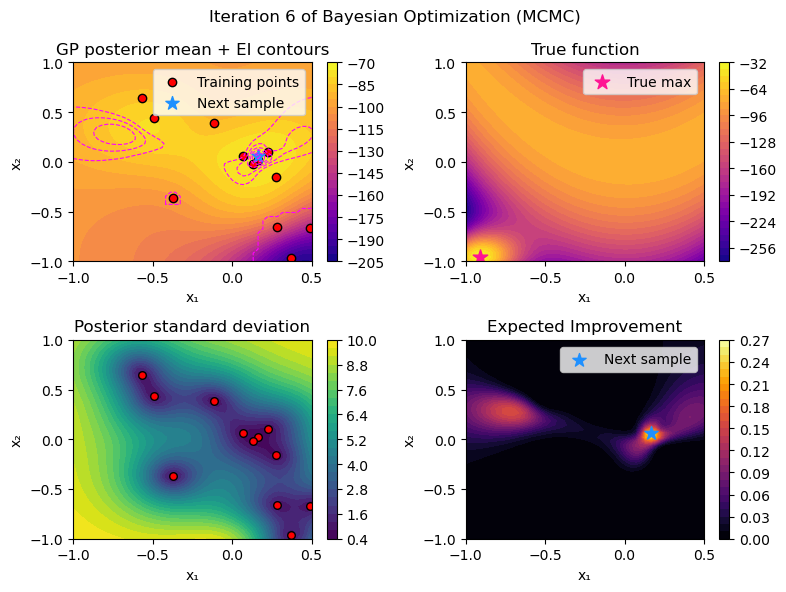


--- Iteration 7 ---
9.979852 2.0604656 0.29163346


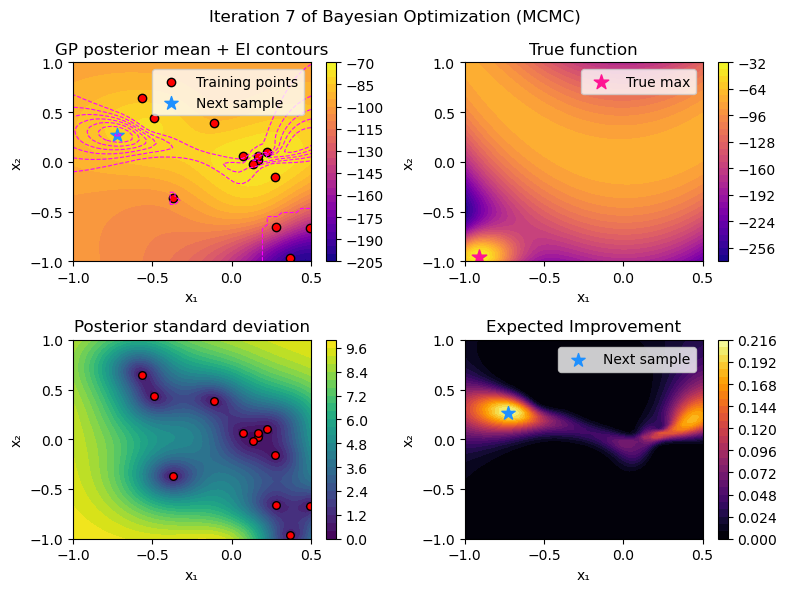


--- Iteration 8 ---
9.983995 2.0170574 0.7638575


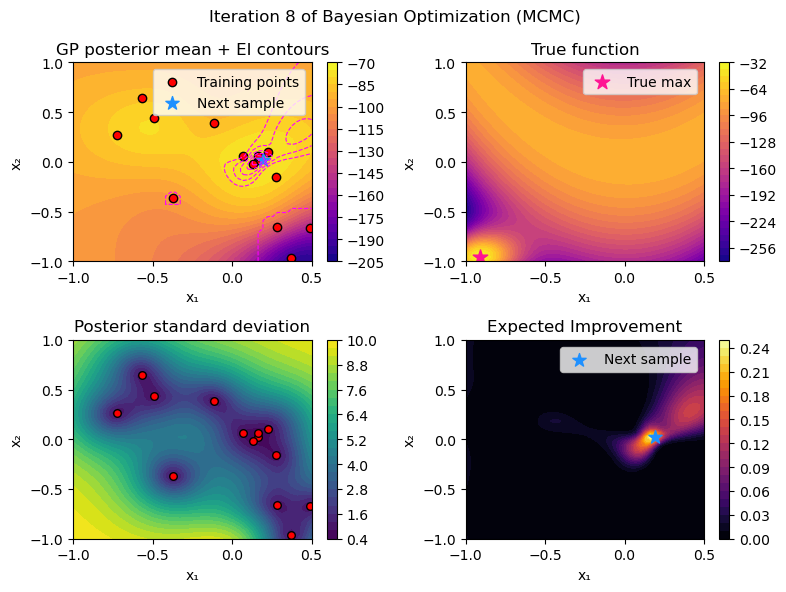


--- Iteration 9 ---
9.98489 2.0118084 0.44445068


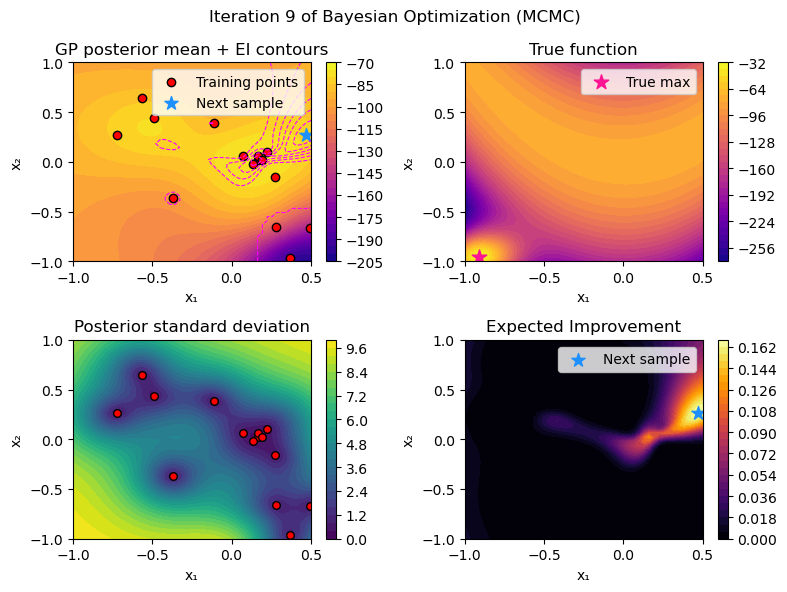


--- Iteration 10 ---
9.983986 1.9615939 0.46694022


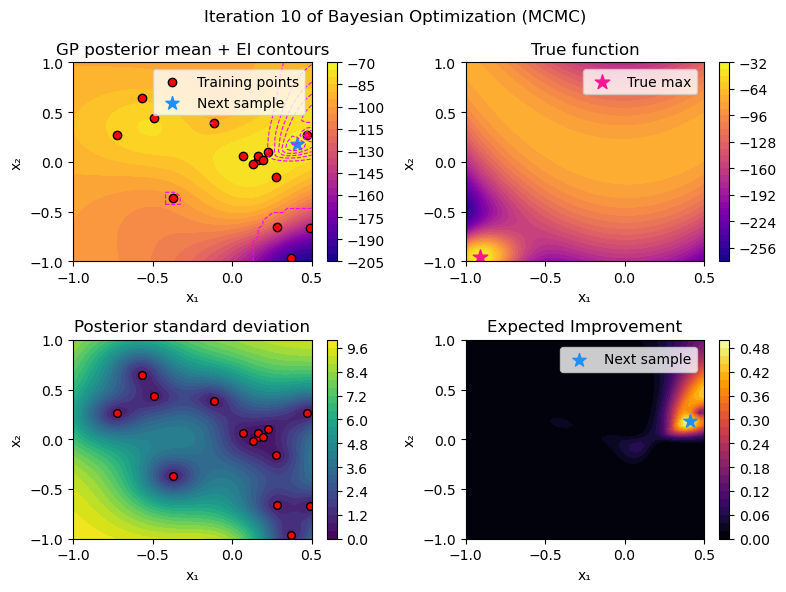


--- Iteration 11 ---
9.98417 1.9280005 0.40307283


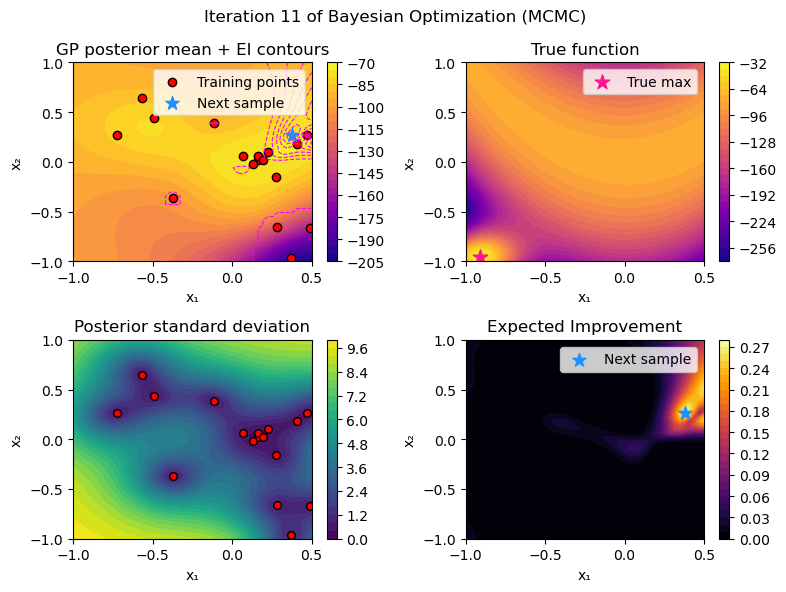


--- Iteration 12 ---
9.981688 1.9108747 0.30495232


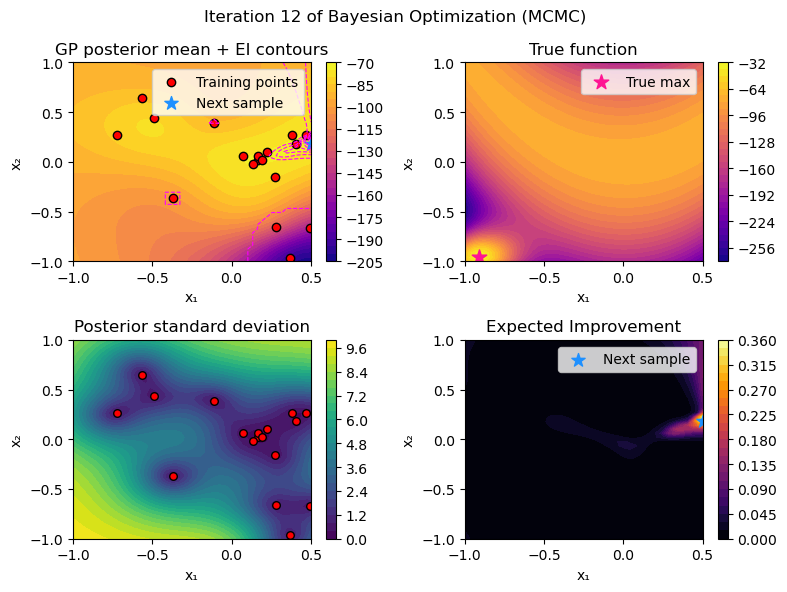


--- Iteration 13 ---
9.983268 1.909174 0.4261707


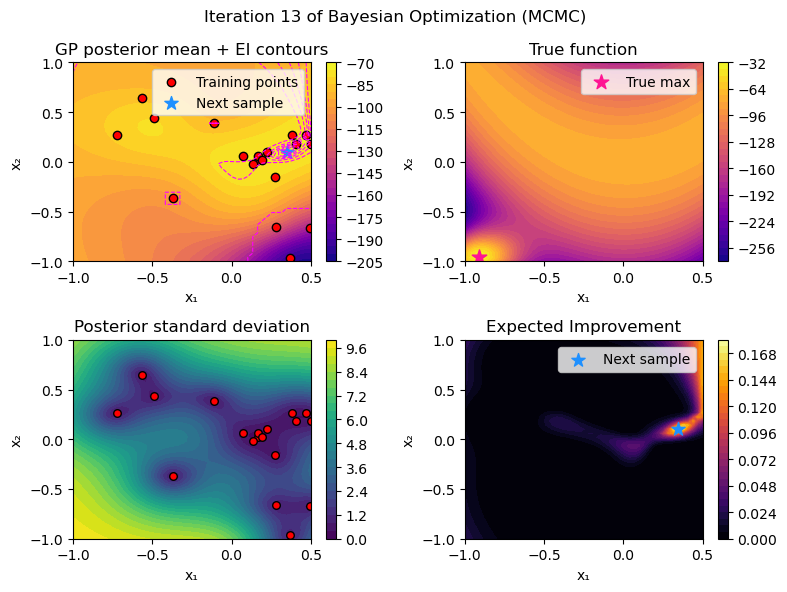


--- Iteration 14 ---
9.983554 1.9180658 0.2472732


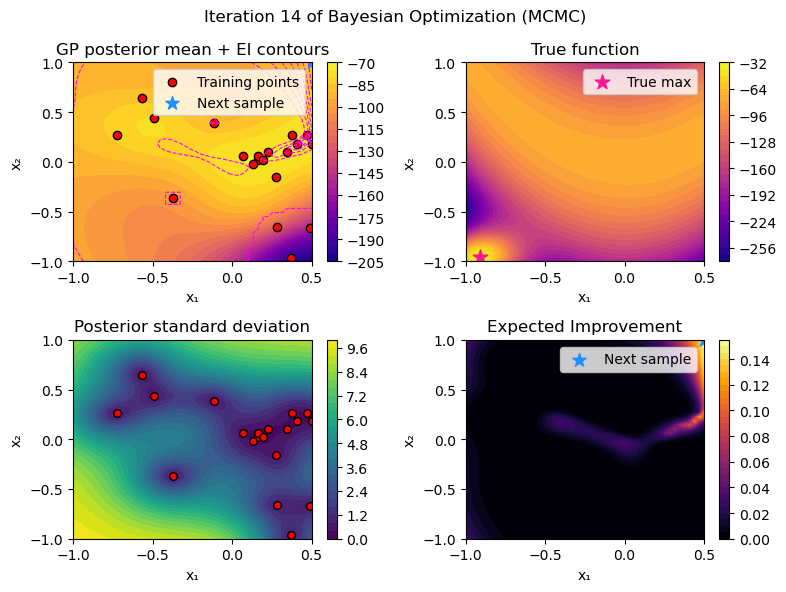


--- Iteration 15 ---
9.988277 1.7817416 0.40195957


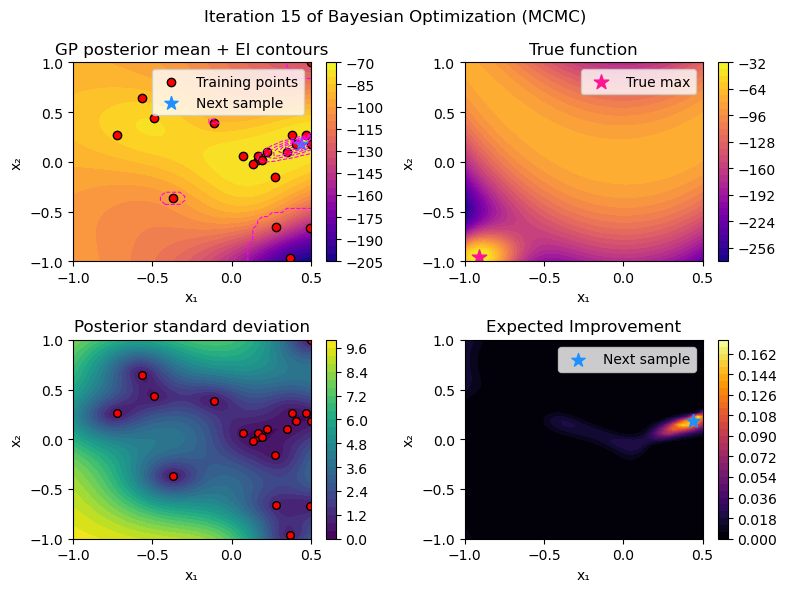


--- Iteration 16 ---


In [ ]:

import numpyro
numpyro.set_host_device_count(100)

import jax.numpy as jnp
import jax.random as random

from config import load_initial_data, NOISE_STD, KEY 
from config import f_rosenbrock, f_hosaki, f_bird, f_ursem
from model import compute_posterior, mu_0_factory
from inference import (
    run_mcmc,
    expected_improvement_acquisition_function,
    compute_posterior_from_mcmc, 
    average_acquisition_over_posterior_samples,
)
from plotting import plot_gp_results

# ===============================
# MAIN MCMC-BASED BAYESIAN OPTIMIZATION LOOP
# ===============================

function_name = "f_rosenbrock"
function_map = {
    "f_rosenbrock": f_rosenbrock,
    "f_hosaki": f_hosaki,
    "f_bird": f_bird,
    "f_ursem" : f_ursem
}

f_true = function_map[function_name]
X, y, X_new = load_initial_data(function_name)
MAX_ITER = 20
patience = 5
improvement_threshold = 1e-4
no_improvement_counter = 0
best_y = jnp.max(y)
for iteration in range(MAX_ITER):
    print(f"\n--- Iteration {iteration + 1} ---")

    # Step 1: Run MCMC to sample hyperparameters
    key = random.PRNGKey(iteration)
    samples = run_mcmc(X, y, key)
    mu_0_fn = mu_0_factory(y)
    avg_alpha, x_next, idx_next = average_acquisition_over_posterior_samples(
        X_train=X,
        y_train=y,
        X_new=X_new,
        posterior_fn=compute_posterior,
        mu_0=mu_0_fn,
        samples=samples,
    )



    # Step 4: To visualize, compute posterior mean and std from averaged posterior (optional)
    posterior_means, posterior_stds = compute_posterior_from_mcmc(
        X, y, X_new, compute_posterior, samples, mu_0_fn
    )

    # Step 5: Plot results
    plot_gp_results(
        X,
        y,
        X_new,
        posterior_means,
        posterior_stds,
        avg_alpha,
        idx_next,
        noise_std=NOISE_STD,
        true_fn=f_true,
        title=f"Iteration {iteration + 1} of Bayesian Optimization (MCMC)",
    )

    y_next = f_true(x_next.flatten()) + NOISE_STD * random.normal(key, shape=())

    # Early stopping check
    if y_next > best_y + improvement_threshold:
        best_y = y_next
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print(f"Early stopping triggered at iteration {iteration+1}.")
            break

    # Step 7: Append new point to training data
    X = jnp.vstack([X, x_next.reshape(1, -1)])
    y = jnp.append(y, y_next)